# Lab 6 - Analysis of Heterogeneous Reactors
This is a big lab. For the first time we venture outside the territory for which diffusion theory analysis can be used.  This lab includes, what I think to be, a good variety of pratical "experimentation" to investigate the impact of heterogenaity on reactor core physics.

This was also an opportunity for students to use the MCNP plotting features (which I had been avoiding due to the mild complexity of using the MCNP plot system in a Windows environment).  

The idea is to consider a reactor with light water moderator/coolant and low enriched uranium (metallic) fuel.  We will consider the following cases:

a) homogeneous reactor with water, U-238 and U-235 all mixed together;

b) A uranium metal fuel pin in a water tank (of the same size as the case above); the fuel pin is sized such that the *total* nuber of atoms of each isotope is unchanged; just arranged differently.

c) An arrangement of 4 uranium metallic fuel pins; again the total number of atoms of each isotope is constant from the previous case;

d) A 31x31 lattice of 2cm diameter pins (this will work out to be the same fuel mass and volume; this case is re-run with different lattice pitches. (2.5 cm; 3cm; 3.2cm; and 4cm - though I can pick more and more appropriate values for this analysis...)

## Homogeneous mixture

In [1]:
import openmc
import openmc.model
import numpy as np
import os

Let's make a separte directory for each case so we can go back and look at the data 

In [2]:
if (not os.path.isdir('./homogeneous')): #
    os.mkdir('./homogeneous');
os.chdir('./homogeneous');

### Materials

In [3]:
h_core = openmc.Material(name='core');
h_core.add_nuclide('U238',0.70340,'wo');
h_core.add_nuclide('U235',0.007105,'wo');
h_core.add_nuclide('H1',0.03216,'wo');
h_core.add_nuclide('O16',0.2573,'wo');
h_core.add_s_alpha_beta('c_H_in_H2O');
h_core.set_density('g/cm3',3.06);


In [4]:
mf = openmc.Materials([h_core]);
mf.export_to_xml();

### Geometry
For the homogeneous case, the geometry is just a cylindrical tank 155 cm in height and 75 cm in radius.

In [5]:
core_tank = openmc.model.RightCircularCylinder([0.,0.,-5.],
                                              150.,radius=75.,
                                               axis='z',
                                              boundary_type='vacuum');


In [6]:
core_cell = openmc.Cell();
core_cell.fill = h_core;
core_cell.region = -core_tank;

root_universe = openmc.Universe();
root_universe.add_cells([core_cell]);

geometry = openmc.Geometry(root_universe);
geometry.export_to_xml();


### Tallies
Let's set up some tallies to keep track of absorption/capture/etc... in the fuel and moderator.

In [7]:
energy_filter = openmc.EnergyFilter([0.,0.625,20.e6]);
cell_filter = openmc.CellFilter([core_cell]);

tallies = openmc.Tallies()

t_abs = openmc.Tally(name='abs. tally');
t_abs.filters = [energy_filter,cell_filter];
t_abs.scores = ['absorption'];
t_abs.nuclides = ['H1','O16','U235','U238'];
tallies.append(t_abs);


t_fiss = openmc.Tally(name='fission tally');
t_fiss.filters = [energy_filter,cell_filter];
t_fiss.nuclides = ['U235','U238'];
t_fiss.scores = ['fission','nu-fission'];
tallies.append(t_fiss);

tallies.export_to_xml();



### Settings
(will want to add tallies later...)

In [8]:
settings = openmc.Settings();
settings.batches = 250;
settings.inactive = 100;
settings.particles = 10000;

bounds = [-75.,-75.,-5.,75.,75.,145.];
uniform_dist = openmc.stats.Box(bounds[:3],bounds[3:],
                               only_fissionable=True);
settings.source = openmc.source.Source(space=uniform_dist);

settings.export_to_xml();


In [9]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      174/1    0.86985    0.89185 +/- 0.00132
      175/1    0.88868    0.89181 +/- 0.00131
      176/1    0.90083    0.89193 +/- 0.00129
      177/1    0.90752    0.89213 +/- 0.00129
      178/1    0.89770    0.89220 +/- 0.00128
      179/1    0.88196    0.89207 +/- 0.00127
      180/1    0.90211    0.89220 +/- 0.00126
      181/1    0.90316    0.89233 +/- 0.00125
      182/1    0.89789    0.89240 +/- 0.00124
      183/1    0.88194    0.89227 +/- 0.00123
      184/1    0.88873    0.89223 +/- 0.00121
      185/1    0.89478    0.89226 +/- 0.00120
      186/1    0.87815    0.89210 +/- 0.00120
      187/1    0.88809    0.89205 +/- 0.00118
      188/1    0.88744    0.89200 +/- 0.00117
      189/1    0.88956    0.89197 +/- 0.00116
      190/1    0.90255    0.89209 +/- 0.00115
      191/1    0.88403    0.89200 +/- 0.00114
      192/1    0.90540    0.89215 +/- 0.00114
      193/1    0.88134    0.89203 +/- 0.00113
      194/1    0.90074    0.89212 +/- 0.00113
      195/1    0.88397    0.89204 

The reported $k_{\text{eff}}$ of 0.89210 is slightly different than my MCNP result (0.88996).

Further investigation revealed that in the MCNP output to which I'm comparing, I didn't use the thermal scattering treatment for the light water.  If I take out the s_alpha_beta from the OpenMC model the revised k_eff is 0.89051 which is closer to the same result.  Lesson learned (again!): that shit matters! 

In [10]:
sp = openmc.StatePoint('statepoint.250.h5');
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	abs. tally
 	Filters        =	EnergyFilter, CellFilter
 	Nuclides       =	H1 O16 U235 U238
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 2: Tally
 	ID             =	2
 	Name           =	fission tally
 	Filters        =	EnergyFilter, CellFilter
 	Nuclides       =	U235 U238
 	Scores         =	['fission', 'nu-fission']
 	Estimator      =	tracklength}

In [11]:
abs_rate = sp.get_tally(name='abs. tally');
ar_df = abs_rate.get_pandas_dataframe();
ar_df.head(10)



,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.000,6.250000e-01,1,H1,absorption,0.209772,2.119370e-04
1,0.000,6.250000e-01,1,O16,absorption,0.000061,6.115748e-08
2,0.000,6.250000e-01,1,U235,absorption,0.396307,4.039761e-04
3,0.000,6.250000e-01,1,U238,absorption,0.157535,1.589230e-04
4,0.625,2.000000e+07,1,H1,absorption,0.005354,3.762504e-06
5,0.625,2.000000e+07,1,O16,absorption,0.002373,8.649800e-06
6,0.625,2.000000e+07,1,U235,absorption,0.015828,1.170157e-05
7,0.625,2.000000e+07,1,U238,absorption,0.177426,2.680464e-04


In [12]:
total_abs = ar_df['mean'].sum();
print(f'Total absorption per source particle: %5.4f'%total_abs);
print(f'Leakage per source particle: %5.4f'%(1-total_abs));

Total absorption per source particle: 0.9647
Leakage per source particle: 0.0353


This leakage percent is close to what MCNP gives (3.91%) - but, remember, the MCNP input (for some reason) did not include thermal scattering treatment.  (if I re-try this without thermal scattering treatment: I get leakage per source particle of 3.85% which is closer to the MCNP result - consistent.)

In [13]:
fiss_rate = sp.get_tally(name='fission tally');
fr_df = fiss_rate.get_pandas_dataframe();
fr_df.head(10)

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.000,6.250000e-01,1,U235,fission,3.382861e-01,3.449188e-04
1,0.000,6.250000e-01,1,U235,nu-fission,8.243017e-01,8.404637e-04
2,0.000,6.250000e-01,1,U238,fission,9.847288e-07,9.940261e-10
3,0.000,6.250000e-01,1,U238,nu-fission,2.454031e-06,2.477200e-09
4,0.625,2.000000e+07,1,U235,fission,1.060416e-02,7.689840e-06
5,0.625,2.000000e+07,1,U235,nu-fission,2.597723e-02,1.874295e-05
6,0.625,2.000000e+07,1,U238,fission,1.497145e-02,1.649006e-05
7,0.625,2.000000e+07,1,U238,nu-fission,4.207021e-02,4.868483e-05


In [14]:
fiss = fr_df[fr_df['score']=='fission'];
total_fission = fiss['mean'].sum()
print(f'Total fission: %5.4f per source particle'%total_fission);

Total fission: 0.3639 per source particle


In [15]:
fiss.head()

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.000,6.250000e-01,1,U235,fission,3.382861e-01,3.449188e-04
2,0.000,6.250000e-01,1,U238,fission,9.847288e-07,9.940261e-10
4,0.625,2.000000e+07,1,U235,fission,1.060416e-02,7.689840e-06
6,0.625,2.000000e+07,1,U238,fission,1.497145e-02,1.649006e-05


I'm sure a lot more can be done here, but I want to move on to the next case, for now.

In [16]:
os.chdir('..')
if (not os.path.isdir('./one_pin')): #
    os.mkdir('./one_pin');
os.chdir('./one_pin');

## One Pin
Here I will collect all of the uranium in the homogeneous core mixture and combine into a single pin.  This pin will be placed into a tank of water the same size as before

### Material


In [17]:
fuel = openmc.Material(name='fuel');
fuel.add_nuclide('U238',0.99,'wo');
fuel.add_nuclide('U235',0.01,'wo');
fuel.set_density('g/cm3',19.1);

mod = openmc.Material(name='mod');
mod.add_nuclide('H1',2,'ao');
mod.add_nuclide('O16',1,'ao');
mod.add_s_alpha_beta('c_H_in_H2O');
mod.set_density('g/cm3',1.0);

mf = openmc.Materials();
mf += [fuel,mod];

mf.export_to_xml();

### Geometry
The fuel pin is a rcc 100 cm high and 31 cm in radius.  This sits inside the larger cylindrical tank (same dimensions of the homogeneous core) already defined as "core_tank"  

In [18]:
fuel_pin = openmc.model.RightCircularCylinder([0.,0.,0.],
                                              100.,radius=31.,
                                               axis='z');

fuel_cell = openmc.Cell();
fuel_cell.fill = fuel;
fuel_cell.region = -fuel_pin;

rx_tank = openmc.Cell();
rx_tank.fill = mod;
rx_tank.region = +fuel_pin & -core_tank;

root = openmc.Universe();
root.add_cells([fuel_cell,rx_tank]);

geometry = openmc.Geometry();
geometry.root_universe = root;

geometry.export_to_xml();

### Tallies
I will use the same tallies but I'll need to change the cell filters for the current geometry so some adjustment to the objects will be required.

In [19]:
#energy_filter = openmc.EnergyFilter([0.,0.625,20.e6]); #<-- keep this for reference

fuel_cell_filter = openmc.CellFilter([fuel_cell]);
rx_tank_cell_filter = openmc.CellFilter([rx_tank]);

tallies = openmc.Tallies()

abs_fuel = openmc.Tally(name='abs. fuel');
abs_fuel.filters = [energy_filter,fuel_cell_filter];
abs_fuel.scores = ['absorption'];
abs_fuel.nuclides = ['U235','U238'];
tallies.append(abs_fuel);

abs_mod = openmc.Tally(name='abs. mod');
abs_mod.filters = [energy_filter,rx_tank_cell_filter];
abs_mod.nuclides = ['H1','O16'];
abs_mod.scores = ['absorption'];
tallies.append(abs_mod);



t_fiss = openmc.Tally(name='fission tally');
t_fiss.filters = [energy_filter,fuel_cell_filter];
t_fiss.nuclides = ['U235','U238'];
t_fiss.scores = ['fission','nu-fission'];
tallies.append(t_fiss);

tallies.export_to_xml();

### Settings
I will use mostly the same settings.  I just want to change the bounding box so it now only encompases the fuel region.  Probably not strictly required but anyway...

In [20]:
bounds = [-31.,-31.,0.,31.,31.,100.];
uniform_dist = openmc.stats.Box(bounds[:3],bounds[3:],
                               only_fissionable=True);
settings.source = openmc.source.Source(space=uniform_dist);

settings.export_to_xml();

In [21]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      175/1    0.51772    0.52362 +/- 0.00090
      176/1    0.51801    0.52355 +/- 0.00090
      177/1    0.52162    0.52352 +/- 0.00088
      178/1    0.53389    0.52365 +/- 0.00088
      179/1    0.53264    0.52377 +/- 0.00088
      180/1    0.52597    0.52379 +/- 0.00087
      181/1    0.52792    0.52385 +/- 0.00086
      182/1    0.52912    0.52391 +/- 0.00085
      183/1    0.52894    0.52397 +/- 0.00084
      184/1    0.53159    0.52406 +/- 0.00084
      185/1    0.52691    0.52409 +/- 0.00083
      186/1    0.51926    0.52404 +/- 0.00082
      187/1    0.52878    0.52409 +/- 0.00081
      188/1    0.51491    0.52399 +/- 0.00081
      189/1    0.52828    0.52404 +/- 0.00080
      190/1    0.51665    0.52395 +/- 0.00080
      191/1    0.51971    0.52391 +/- 0.00079
      192/1    0.53058    0.52398 +/- 0.00079
      193/1    0.52248    0.52396 +/- 0.00078
      194/1    0.53427    0.52407 +/- 0.00078
      195/1    0.52922    0.52413 +/- 0.00077
      196/1    0.54016    0.52430 

The result is much closer to the MCNP result (why?).  The main difference from the homgeneous case is an increase in neutron capture.  S

The tallies will now be analyzed to determine:
a) where does most of the neutron capture occur;
b) in which nuclide; and
c) at what energy

In [22]:
sp = openmc.StatePoint('statepoint.250.h5');
sp.tallies

{3: Tally
 	ID             =	3
 	Name           =	abs. fuel
 	Filters        =	EnergyFilter, CellFilter
 	Nuclides       =	U235 U238
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 4: Tally
 	ID             =	4
 	Name           =	abs. mod
 	Filters        =	EnergyFilter, CellFilter
 	Nuclides       =	H1 O16
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 5: Tally
 	ID             =	5
 	Name           =	fission tally
 	Filters        =	EnergyFilter, CellFilter
 	Nuclides       =	U235 U238
 	Scores         =	['fission', 'nu-fission']
 	Estimator      =	tracklength}

In [23]:
abs_fuel = sp.get_tally(name='abs. fuel');
abs_fuel_df = abs_fuel.get_pandas_dataframe();
abs_fuel_df.head(10)

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.000,6.250000e-01,2,U235,absorption,0.092862,0.000261
1,0.000,6.250000e-01,2,U238,absorption,0.038763,0.000110
2,0.625,2.000000e+07,2,U235,absorption,0.052870,0.000104
3,0.625,2.000000e+07,2,U238,absorption,0.428358,0.000530


In [24]:
abs_mod = sp.get_tally(name='abs. mod');
abs_mod_df = abs_mod.get_pandas_dataframe();
abs_mod_df.head(10)

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.000,6.250000e-01,3,H1,absorption,0.364923,5.715463e-04
1,0.000,6.250000e-01,3,O16,absorption,0.000104,1.635823e-07
2,0.625,2.000000e+07,3,H1,absorption,0.003477,4.191605e-06
3,0.625,2.000000e+07,3,O16,absorption,0.000695,6.255310e-06


A brief glance at the above results indicate that the vast majority of the absorptions are happeinging:
a) epithermal and fast neutrons in U238; and
b) thermal neutrons in H1 in the moderator.



In [25]:
os.chdir('..')
if (not os.path.isdir('./four_pins')): #
    os.mkdir('./four_pins');
os.chdir('./four_pins');

## 4-Pins
In this iteration we divide the 1 large pin into 4 equally sized pins that, cumulatively, has the same volume as the single pin.  In making this change we should see a reduction in capture in U-238 but - well, let's just do it and find out for sure.  While we're at it, we will practice making lattices in OpenMC, practice plotting the geometry, and learn how to do tallies in lattices.

### Materials

There are no changes to the materials for this part of the project so we will merely export the existing materials object to xml.

In [26]:
# no changes; create a local copy of the xml file.
mf.export_to_xml();

# reminder the two materials are:
# fuel - 1% enriched uranium fuel 
# mod - light water moderator

### Geometry
I will make a 2x2 lattice of the fuel pins.  The lattice pitch is 38 cm; the entire area is in a RPP centered on the origin that is 76 cm square and 100 cm tall.

In [27]:
pitch = 38; #cm
fuel_radius = 15.5; #cm

# create a RCC for a generic fuel pin in the fuel pin universe

fuel_pin = openmc.model.RightCircularCylinder([0.,0.,0.],100.,
                                              radius=fuel_radius,
                                              axis='z');

fp_fuel = openmc.Cell(name='fuel');
fp_fuel.fill = fuel;
fp_fuel.region = -fuel_pin;

fp_mod = openmc.Cell(name='mod in fuel');
fp_mod.fill = mod;
fp_mod.region = +fuel_pin;

fp = openmc.Universe();
fp.add_cells((fp_fuel,fp_mod));

mod_cell = openmc.Cell();
mod_cell.fill = mod;

all_water = openmc.Universe();
all_water.add_cell(mod_cell);




In [28]:
colors = {}
colors[mod] = 'blue';
colors[fuel] = 'yellow';

In [29]:
# let's make some other plots
main = openmc.Cell();
main.fill = fp;

root = openmc.Universe();
root.add_cell(main);

g = openmc.Geometry();
g.root_universe = root;
g.export_to_xml();


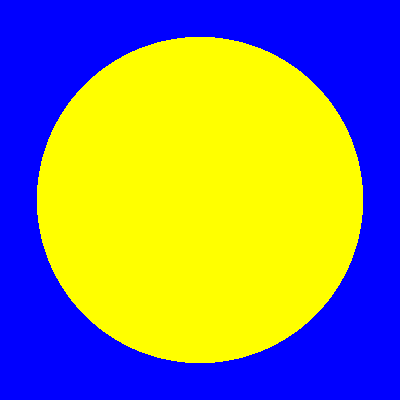

In [30]:
p = openmc.Plot();
p.width = [pitch,pitch];
p.pixels = [400,400];
p.origin = [0.,0.,10.];
#p.basis = 'xy';
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [31]:
# maybe you don't really need this?
core_area = openmc.model.RectangularParallelepiped(-38.,38.,-38.,38.,
                                                  0.,100.);

lattice = openmc.RectLattice();
lattice.dimension = [2,2];
lattice.lower_left = [-pitch,-pitch];
lattice.pitch = [pitch,pitch];

lattice.universes = [
    [fp,fp],
    [fp,fp]
];

lattice.outer = all_water;

core_cell = openmc.Cell();
core_cell.fill = lattice;
core_cell.region = -core_area;

refl_cell = openmc.Cell();
refl_cell.fill = mod;
refl_cell.region = +core_area & -core_tank;



#main = openmc.Cell()
#main.fill = lattice;

root = openmc.Universe();
root.add_cells([core_cell,refl_cell]);

g = openmc.Geometry();
g.root_universe = root;
g.export_to_xml();


I think this should all "work" -- even if it's not the best thing ever written.  To be sure, it's a good idea to make a plot to be sure

In [32]:
colors = {}
colors[mod] = 'blue';
colors[fuel] = 'yellow';

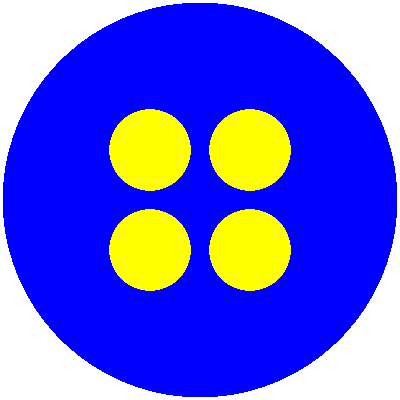

In [33]:
p = openmc.Plot();
p.width = [4*pitch,4*pitch];
p.origin = [0.,0.,10.];
p.pixels = [400,400];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

Okay...this looks correct now.

In [34]:



fuel_cell_filter = openmc.DistribcellFilter([fp_fuel]);
mod_in_fuel_filter = openmc.DistribcellFilter([fp_mod]);
rfl_cell_filter = openmc.CellFilter([refl_cell]);

tallies = openmc.Tallies()

abs_fuel = openmc.Tally(name='abs. fuel');
abs_fuel.filters = [energy_filter,fuel_cell_filter];
abs_fuel.scores = ['absorption'];
abs_fuel.nuclides = ['U235','U238'];
tallies.append(abs_fuel);

abs_mod_ref = openmc.Tally(name='abs. mod refl');
abs_mod_ref.filters = [energy_filter,rfl_cell_filter];
abs_mod_ref.nuclides = ['H1','O16'];
abs_mod_ref.scores = ['absorption'];
tallies.append(abs_mod_ref);

abs_mod_fuel = openmc.Tally(name='abs. mod fuel');
abs_mod_fuel.filters = [energy_filter,mod_in_fuel_filter];
abs_mod_fuel.nuclides = ['H1','O16'];
abs_mod_fuel.scores = ['absorption'];
tallies.append(abs_mod_fuel);


t_fiss = openmc.Tally(name='fission tally');
t_fiss.filters = [energy_filter,fuel_cell_filter];
t_fiss.nuclides = ['U235','U238'];
t_fiss.scores = ['fission','nu-fission'];
tallies.append(t_fiss);

tallies.export_to_xml();

settings.export_to_xml();


In [35]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      175/1    0.59524    0.60049 +/- 0.00114
      176/1    0.59280    0.60039 +/- 0.00113
      177/1    0.59241    0.60028 +/- 0.00112
      178/1    0.60111    0.60029 +/- 0.00111
      179/1    0.61095    0.60043 +/- 0.00110
      180/1    0.59013    0.60030 +/- 0.00110
      181/1    0.59562    0.60024 +/- 0.00108
      182/1    0.60547    0.60031 +/- 0.00107
      183/1    0.59763    0.60027 +/- 0.00106
      184/1    0.59566    0.60022 +/- 0.00105
      185/1    0.60903    0.60032 +/- 0.00104
      186/1    0.59479    0.60026 +/- 0.00103
      187/1    0.60387    0.60030 +/- 0.00102
      188/1    0.59649    0.60026 +/- 0.00101
      189/1    0.60549    0.60032 +/- 0.00100
      190/1    0.62678    0.60061 +/- 0.00103
      191/1    0.60258    0.60063 +/- 0.00102
      192/1    0.62103    0.60085 +/- 0.00103
      193/1    0.59488    0.60079 +/- 0.00102
      194/1    0.61401    0.60093 +/- 0.00102
      195/1    0.61102    0.60104 +/- 0.00102
      196/1    0.60081    0.60103 

Once again; this is much like the MCNP result.

In [36]:
sp = openmc.StatePoint('statepoint.250.h5');
sp.tallies


{6: Tally
 	ID             =	6
 	Name           =	abs. fuel
 	Filters        =	EnergyFilter, DistribcellFilter
 	Nuclides       =	U235 U238
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 7: Tally
 	ID             =	7
 	Name           =	abs. mod refl
 	Filters        =	EnergyFilter, CellFilter
 	Nuclides       =	H1 O16
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 8: Tally
 	ID             =	8
 	Name           =	abs. mod fuel
 	Filters        =	EnergyFilter, DistribcellFilter
 	Nuclides       =	H1 O16
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 9: Tally
 	ID             =	9
 	Name           =	fission tally
 	Filters        =	EnergyFilter, DistribcellFilter
 	Nuclides       =	U235 U238
 	Scores         =	['fission', 'nu-fission']
 	Estimator      =	tracklength}

In [37]:
abs_fuel = sp.get_tally(name='abs. fuel');
abs_fuel_df = abs_fuel.get_pandas_dataframe();
#abs_fuel_df.head(25)

In [38]:
u235_abs = abs_fuel_df[(abs_fuel_df['nuclide']=='U235')]['mean'].sum()
print(f'Absorptioni in U235: %5.4f'%u235_abs);

Absorptioni in U235: 0.1905


In [39]:
u238_abs = abs_fuel_df[abs_fuel_df['nuclide']=='U238']['mean'].sum()
print(f'Absorptioni in U238: %5.4f'%u238_abs);

Absorptioni in U238: 0.3844


In [40]:
abs_mod_refl = sp.get_tally(name='abs. mod refl');
abs_mod_refl_df = abs_mod_refl.get_pandas_dataframe();
abs_mod_refl_df.head(25)

,energy low [eV],energy high [eV],cell,nuclide,score,mean,std. dev.
0,0.000,6.250000e-01,9,H1,absorption,0.116528,3.999647e-04
1,0.000,6.250000e-01,9,O16,absorption,0.000033,1.144743e-07
2,0.625,2.000000e+07,9,H1,absorption,0.000778,2.819935e-06
3,0.625,2.000000e+07,9,O16,absorption,0.000181,3.078471e-06


In [41]:
total_abs_mod_refl = abs_mod_refl_df['mean'].sum();
print(f'total absorption in moderator in reflector region: %5.4f'%total_abs_mod_refl);

total absorption in moderator in reflector region: 0.1175


In [42]:
abs_mod_fuel = sp.get_tally(name='abs. mod fuel');
abs_mod_fuel_df = abs_mod_fuel.get_pandas_dataframe();
#abs_mod_fuel_df.head(25)

In [43]:
total_abs_mod_fuel = abs_mod_fuel_df['mean'].sum()
print(f'total absorption in the moderator in the core region: %5.4f'%total_abs_mod_fuel);

total absorption in the moderator in the core region: 0.2948


In [44]:
total_mod_abs = total_abs_mod_fuel+total_abs_mod_refl;
print(f'total absorption in moderator material: %5.4f'%total_mod_abs);

total absorption in moderator material: 0.4123


In [45]:
fiss = sp.get_tally(name='fission tally');
fiss_df = fiss.get_pandas_dataframe();
#fiss_df.head(25)

In [46]:
fission = fiss_df[fiss_df['score']=='fission'];
#fission.head(10)

In [47]:
fiss_235 = fission[fission['nuclide']=='U235'];
fiss_238 = fission[fission['nuclide']=='U238'];
fiss_235.head(10)


energy low [eV] energy high [eV] level 1      level 2       level 3       \
                                       univ cell     lat          univ cell   
                                         id   id      id  x  y      id   id   
0            0.000     6.250000e-01       7    8       6  0  0       3    4   
4            0.000     6.250000e-01       7    8       6  1  0       3    4   
8            0.000     6.250000e-01       7    8       6  0  1       3    4   
12           0.000     6.250000e-01       7    8       6  1  1       3    4   
16           0.625     2.000000e+07       7    8       6  0  0       3    4   
20           0.625     2.000000e+07       7    8       6  1  0       3    4   
24           0.625     2.000000e+07       7    8       6  0  1       3    4   
28           0.625     2.000000e+07       7    8       6  1  1       3    4   

   distribcell nuclide    score      mean std. dev.  
                                                     
                                                     
0            0    U235  fission  0.030679  0.000182  
4            1    U235  fission  0.031721  0.000177  
8            2    U235  fission  0.029596  0.000192  
12           3    U235  fission  0.030602  0.000173  
16           0    U235  fission  0.008758  0.000053  
20           1    U235  fission  0.009211  0.000054  
24           2    U235  fission  0.008540  0.000047  
28           3    U235  fission  0.008753  0.000051

In [48]:
fiss_238.head(10)


energy low [eV] energy high [eV] level 1      level 2       level 3       \
                                       univ cell     lat          univ cell   
                                         id   id      id  x  y      id   id   
2            0.000     6.250000e-01       7    8       6  0  0       3    4   
6            0.000     6.250000e-01       7    8       6  1  0       3    4   
10           0.000     6.250000e-01       7    8       6  0  1       3    4   
14           0.000     6.250000e-01       7    8       6  1  1       3    4   
18           0.625     2.000000e+07       7    8       6  0  0       3    4   
22           0.625     2.000000e+07       7    8       6  1  0       3    4   
26           0.625     2.000000e+07       7    8       6  0  1       3    4   
30           0.625     2.000000e+07       7    8       6  1  1       3    4   

   distribcell nuclide    score          mean     std. dev.  
                                                             
                                                             
2            0    U238  fission  9.320505e-08  5.467000e-10  
6            1    U238  fission  9.640370e-08  5.423423e-10  
10           2    U238  fission  8.994923e-08  5.844830e-10  
14           3    U238  fission  9.297731e-08  5.259288e-10  
18           0    U238  fission  1.909125e-02  9.100600e-05  
22           1    U238  fission  2.016065e-02  9.788008e-05  
26           2    U238  fission  1.845580e-02  9.566383e-05  
30           3    U238  fission  1.913616e-02  9.113569e-05

In [49]:
print(f'fission in U238: %5.4f'%fiss_238['mean'].sum());

fission in U238: 0.0768


In [50]:
print(f'fission in U235: %5.4f'%fiss_235['mean'].sum());

fission in U235: 0.1579


In [51]:
os.chdir('..')
if (not os.path.isdir('./31x31_pins')): #
    os.mkdir('./31x31_pins');
os.chdir('./31x31_pins');

## 31x31 lattices
For this section all of the materials, tallies, and settings can remain the same; the geometry will need to be updated to conver the 2x2 lattice of thick rods into a 31x31 lattice of much thinner rods of the same total volume.  We will start by defining a function that creates a new geometry with user input for pitch

In [52]:
def gen_lattice(l_pitch):
    #input lattice pitch
    
    n_pins = 31;
    pin_r = 1.; # cm, fuel pin radius
    
    fuel_pin = openmc.model.RightCircularCylinder([0.,0.,0.],100.,
                                              radius=pin_r,
                                              axis='z');

    fp_fuel = openmc.Cell(name='fuel');
    fp_fuel.fill = fuel;
    fp_fuel.region = -fuel_pin;

    fp_mod = openmc.Cell(name='mod in fuel');
    fp_mod.fill = mod;
    fp_mod.region = +fuel_pin;

    fp = openmc.Universe();
    fp.add_cells((fp_fuel,fp_mod));

    mod_cell = openmc.Cell();
    mod_cell.fill = mod;

    all_water = openmc.Universe();
    all_water.add_cell(mod_cell);
    core_bd = l_pitch*n_pins/2.
    core_area = openmc.model.RectangularParallelepiped(-core_bd,core_bd,-core_bd,core_bd,
                                                  0.,100.);

    lattice = openmc.RectLattice();
    lattice.dimension = [n_pins,n_pins];
    lattice.lower_left = [-core_bd,-core_bd];
    lattice.pitch = [l_pitch,l_pitch];

    lattice.universes = [[ fp for i in range(n_pins)]for j in range(n_pins)];
           

    lattice.outer = all_water;

    core_cell = openmc.Cell();
    core_cell.fill = lattice;
    core_cell.region = -core_area;

    refl_cell = openmc.Cell();
    refl_cell.fill = mod;
    refl_cell.region = +core_area & -core_tank;

    root = openmc.Universe();
    root.add_cells([core_cell,refl_cell]);

    g = openmc.Geometry();
    g.root_universe = root;
    g.export_to_xml();
    
    
    fuel_cell_filter = openmc.DistribcellFilter([fp_fuel]);
    mod_in_fuel_filter = openmc.DistribcellFilter([fp_mod]);
    rfl_cell_filter = openmc.CellFilter([refl_cell]);

    tallies = openmc.Tallies()

    abs_fuel = openmc.Tally(name='abs. fuel');
    abs_fuel.filters = [energy_filter,fuel_cell_filter];
    abs_fuel.scores = ['absorption'];
    abs_fuel.nuclides = ['U235','U238'];
    tallies.append(abs_fuel);

    abs_mod_ref = openmc.Tally(name='abs. mod refl');
    abs_mod_ref.filters = [energy_filter,rfl_cell_filter];
    abs_mod_ref.nuclides = ['H1','O16'];
    abs_mod_ref.scores = ['absorption'];
    tallies.append(abs_mod_ref);

    abs_mod_fuel = openmc.Tally(name='abs. mod fuel');
    abs_mod_fuel.filters = [energy_filter,mod_in_fuel_filter];
    abs_mod_fuel.nuclides = ['H1','O16'];
    abs_mod_fuel.scores = ['absorption'];
    tallies.append(abs_mod_fuel);


    t_fiss = openmc.Tally(name='fission tally');
    t_fiss.filters = [energy_filter,fuel_cell_filter];
    t_fiss.nuclides = ['U235','U238'];
    t_fiss.scores = ['fission','nu-fission'];
    tallies.append(t_fiss);

    tallies.export_to_xml();
    

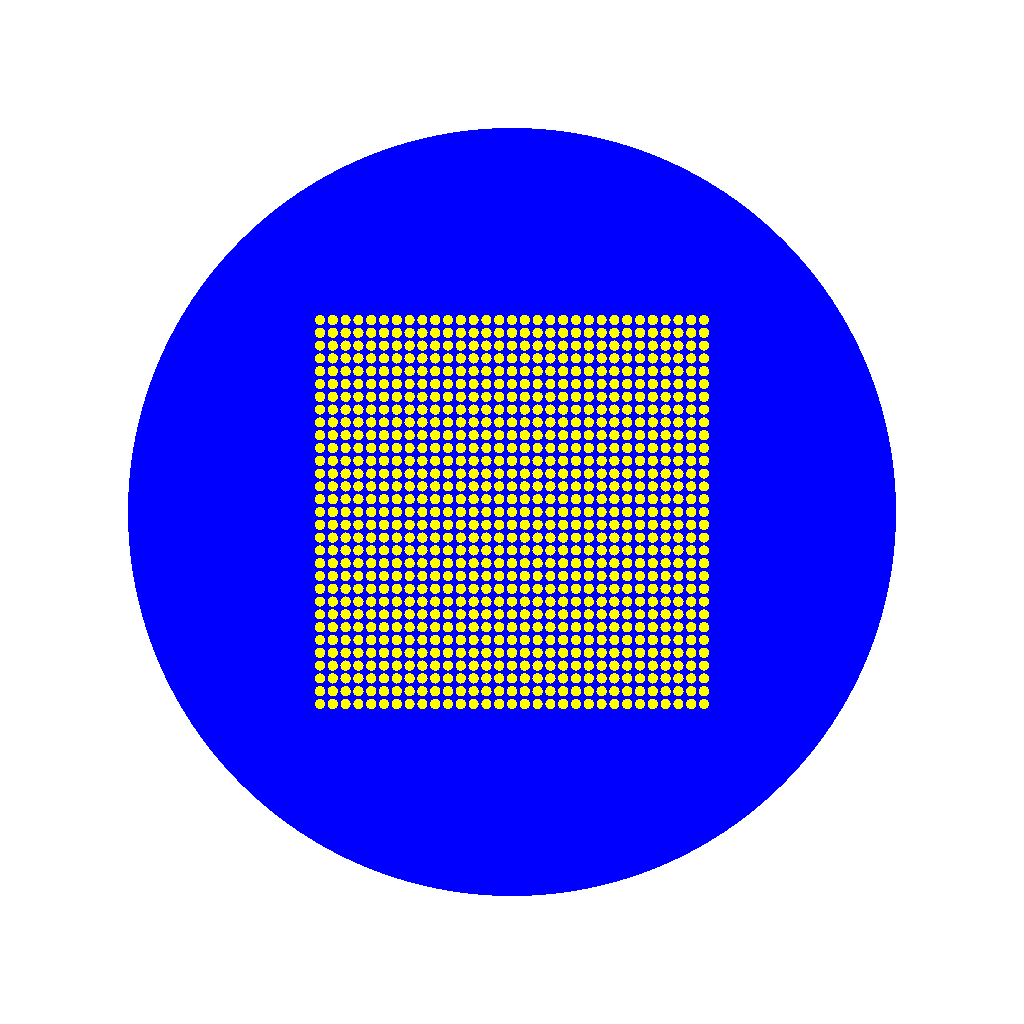

In [53]:
# generate the first geometry and make a plot
if (not os.path.isdir('./p2_5')): #
    os.mkdir('./p2_5');
os.chdir('./p2_5');


mf.export_to_xml();
settings.export_to_xml();
gen_lattice(2.5);
# do without extra tallies for now.

p = openmc.Plot();
p.width = [200., 200.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [54]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      176/1    0.97072    0.96670 +/- 0.00140
      177/1    0.94951    0.96648 +/- 0.00140
      178/1    0.97695    0.96661 +/- 0.00139
      179/1    0.95754    0.96650 +/- 0.00138
      180/1    0.96156    0.96644 +/- 0.00136
      181/1    0.96166    0.96638 +/- 0.00134
      182/1    0.95098    0.96619 +/- 0.00134
      183/1    0.95265    0.96603 +/- 0.00133
      184/1    0.95094    0.96585 +/- 0.00133
      185/1    0.98605    0.96609 +/- 0.00134
      186/1    0.97043    0.96614 +/- 0.00132
      187/1    0.96617    0.96614 +/- 0.00131
      188/1    0.93738    0.96581 +/- 0.00133
      189/1    0.95950    0.96574 +/- 0.00132
      190/1    0.98725    0.96598 +/- 0.00133
      191/1    0.94994    0.96580 +/- 0.00132
      192/1    0.96058    0.96574 +/- 0.00131
      193/1    0.97191    0.96581 +/- 0.00130
      194/1    0.97800    0.96594 +/- 0.00129
      195/1    0.95157    0.96579 +/- 0.00129
      196/1    0.97155    0.96585 +/- 0.00127
      197/1    0.94914    0.96568 

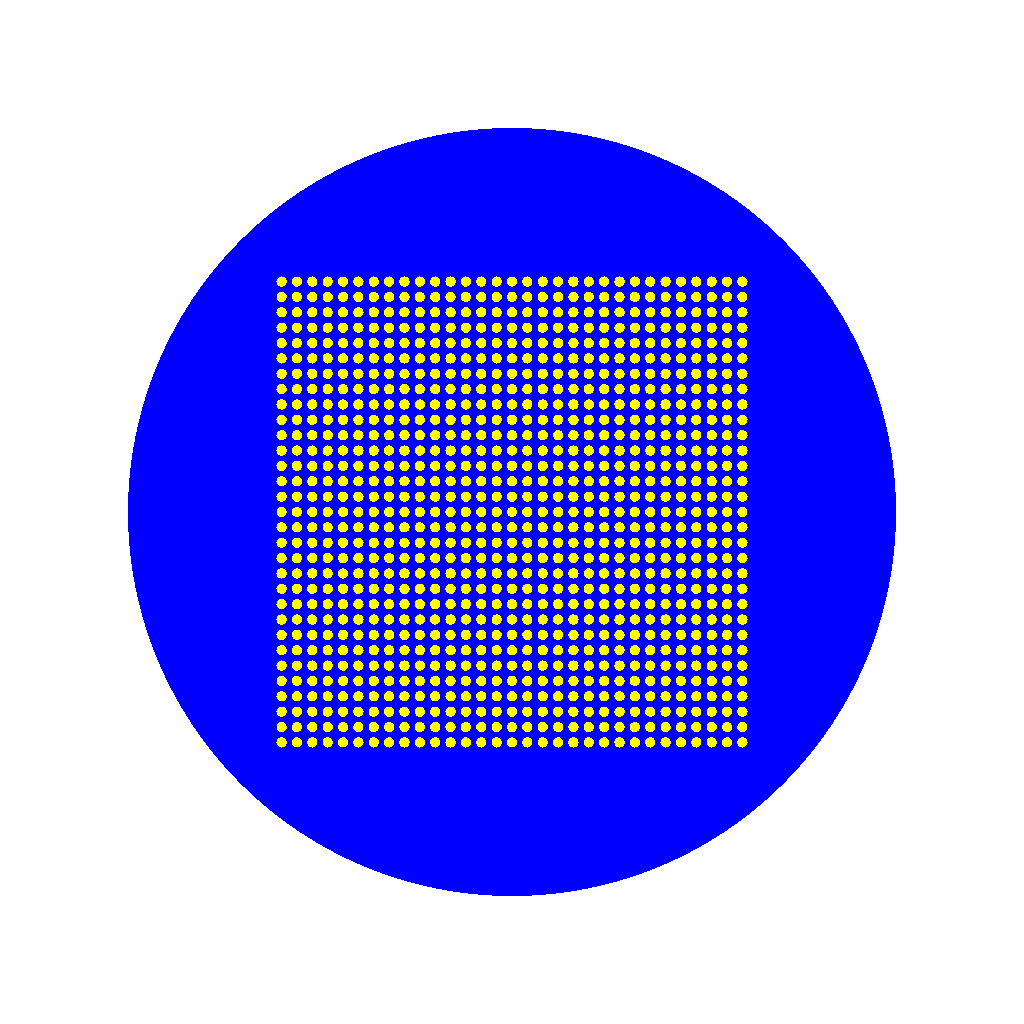

In [55]:
os.chdir('..')
if (not os.path.isdir('./p3_0')): #
    os.mkdir('./p3_0');
os.chdir('./p3_0');


mf.export_to_xml();
settings.export_to_xml();
gen_lattice(3.0);
# do without extra tallies for now.

p = openmc.Plot();
p.width = [200., 200.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [56]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      176/1    1.04595    1.03640 +/- 0.00162
      177/1    1.06120    1.03672 +/- 0.00163
      178/1    1.05918    1.03701 +/- 0.00164
      179/1    1.05313    1.03721 +/- 0.00163
      180/1    1.03545    1.03719 +/- 0.00161
      181/1    1.04121    1.03724 +/- 0.00159
      182/1    1.04192    1.03730 +/- 0.00157
      183/1    1.03602    1.03728 +/- 0.00155
      184/1    1.02901    1.03718 +/- 0.00154
      185/1    1.04344    1.03726 +/- 0.00152
      186/1    1.03898    1.03728 +/- 0.00150
      187/1    1.03106    1.03720 +/- 0.00149
      188/1    1.05657    1.03742 +/- 0.00149
      189/1    1.03075    1.03735 +/- 0.00147
      190/1    1.05912    1.03759 +/- 0.00148
      191/1    1.04675    1.03769 +/- 0.00146
      192/1    1.06637    1.03800 +/- 0.00148
      193/1    1.05223    1.03816 +/- 0.00147
      194/1    1.04259    1.03820 +/- 0.00146
      195/1    1.01847    1.03800 +/- 0.00146
      196/1    1.02737    1.03789 +/- 0.00145
      197/1    1.02599    1.03776 

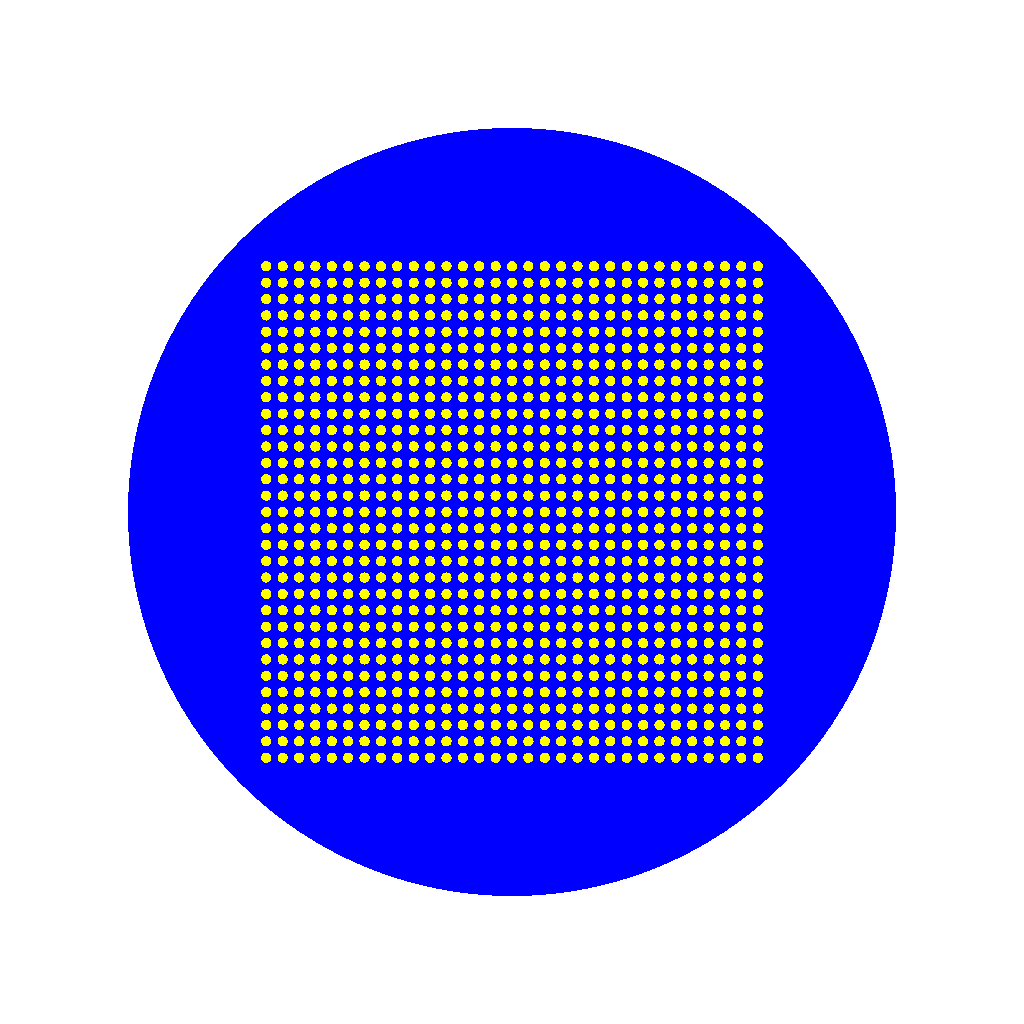

In [57]:
os.chdir('..')
if (not os.path.isdir('./p3_2')): #
    os.mkdir('./p3_2');
os.chdir('./p3_2');


mf.export_to_xml();
settings.export_to_xml();
gen_lattice(3.2);
# do without extra tallies for now.

p = openmc.Plot();
p.width = [200., 200.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [58]:
openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      175/1    1.03485    1.03974 +/- 0.00167
      176/1    1.06004    1.04000 +/- 0.00167
      177/1    1.03290    1.03991 +/- 0.00165
      178/1    1.03436    1.03984 +/- 0.00163
      179/1    1.03357    1.03976 +/- 0.00161
      180/1    1.05117    1.03990 +/- 0.00160
      181/1    1.02850    1.03976 +/- 0.00158
      182/1    1.05387    1.03994 +/- 0.00157
      183/1    1.04735    1.04002 +/- 0.00156
      184/1    1.04755    1.04011 +/- 0.00154
      185/1    1.05016    1.04023 +/- 0.00153
      186/1    1.02583    1.04007 +/- 0.00152
      187/1    1.04472    1.04012 +/- 0.00150
      188/1    1.06314    1.04038 +/- 0.00151
      189/1    1.03234    1.04029 +/- 0.00149
      190/1    1.03883    1.04027 +/- 0.00148
      191/1    1.04304    1.04030 +/- 0.00146
      192/1    1.06327    1.04055 +/- 0.00147
      193/1    1.06359    1.04080 +/- 0.00147
      194/1    1.03421    1.04073 +/- 0.00146
      195/1    1.03447    1.04067 +/- 0.00144
      196/1    1.07003    1.04097 

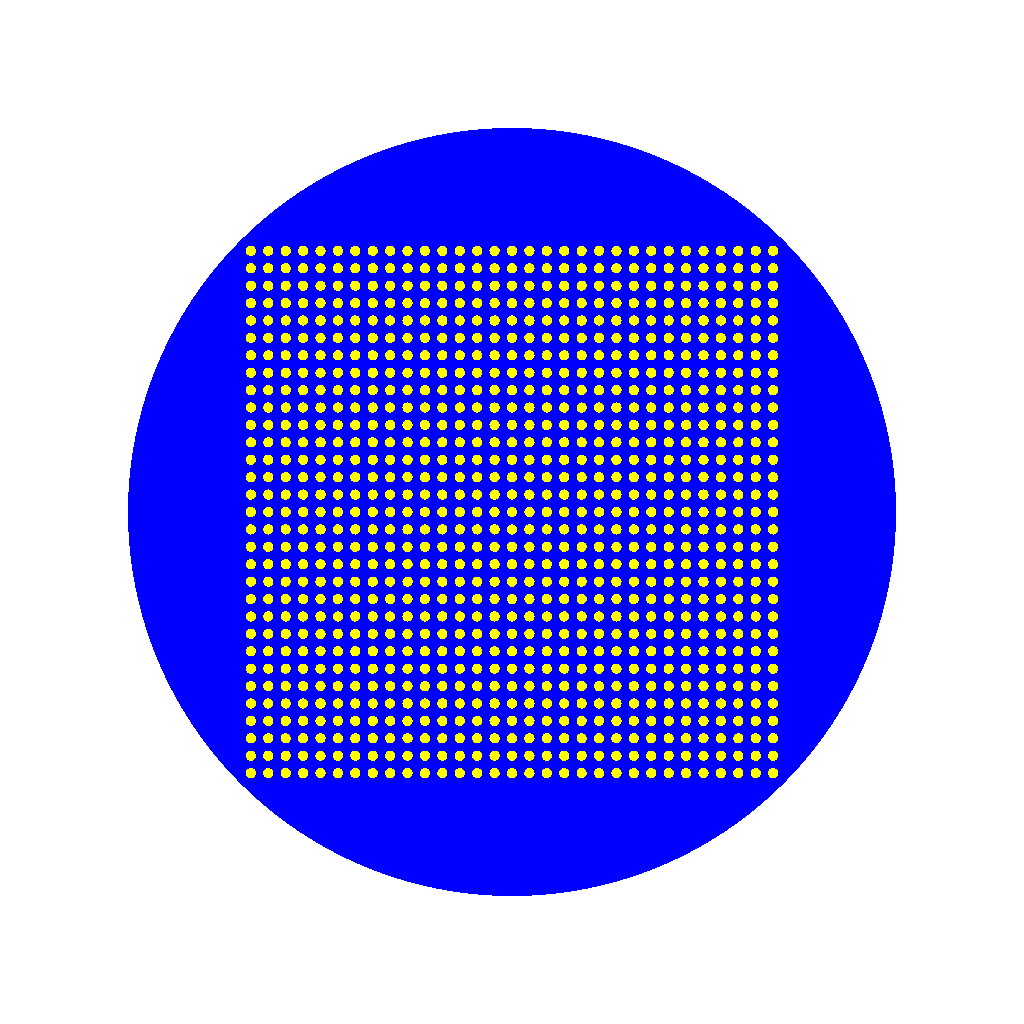

In [59]:
os.chdir('..')
if (not os.path.isdir('./p3_4')): #
    os.mkdir('./p3_4');
os.chdir('./p3_4');


mf.export_to_xml();
settings.export_to_xml();
gen_lattice(3.4);
# do without extra tallies for now.

p = openmc.Plot();
p.width = [200., 200.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [60]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      177/1    1.02791    1.03023 +/- 0.00143
      178/1    1.02766    1.03019 +/- 0.00141
      179/1    1.04081    1.03033 +/- 0.00140
      180/1    1.02675    1.03028 +/- 0.00138
      181/1    1.02818    1.03026 +/- 0.00137
      182/1    1.00553    1.02996 +/- 0.00138
      183/1    1.00852    1.02970 +/- 0.00139
      184/1    1.04215    1.02985 +/- 0.00138
      185/1    1.02589    1.02980 +/- 0.00137
      186/1    1.04086    1.02993 +/- 0.00136
      187/1    1.01378    1.02974 +/- 0.00135
      188/1    1.01890    1.02962 +/- 0.00134
      189/1    1.04782    1.02982 +/- 0.00134
      190/1    1.03275    1.02986 +/- 0.00133
      191/1    1.01283    1.02967 +/- 0.00133
      192/1    1.03011    1.02967 +/- 0.00131
      193/1    1.03279    1.02971 +/- 0.00130
      194/1    1.00785    1.02948 +/- 0.00131
      195/1    1.04002    1.02959 +/- 0.00130
      196/1    1.05404    1.02984 +/- 0.00131
      197/1    1.03274    1.02987 +/- 0.00129
      198/1    1.02550    1.02983 

In [61]:
os.chdir('../..')
if (not os.path.isdir('./partB')): #
    os.mkdir('./partB');
os.chdir('./partB');

## Part B
This will be the same as the 31x31 lattice except the core region will use heavy water and the reflector region will be graphite.

### Materials

In [62]:
fuel = openmc.Material(name='fuel');
fuel.add_nuclide('U238',0.99,'wo');
fuel.add_nuclide('U235',0.01,'wo');
fuel.set_density('g/cm3',19.1);

mod = openmc.Material(name='mod');
mod.add_nuclide('H2',2,'ao');
mod.add_nuclide('O16',1,'ao');
mod.add_s_alpha_beta('c_D_in_D2O');
mod.set_density('g/cm3',1.105);

graph_refl = openmc.Material(name='graph_refl');
graph_refl.add_nuclide('C0',1,'ao');
graph_refl.add_s_alpha_beta('c_Graphite');
graph_refl.set_density('g/cm3',1.7);



mf = openmc.Materials();
mf += [fuel,mod,graph_refl];

mf.export_to_xml();

### Geometry


In [63]:
def gen_lattice_hwg(l_pitch):
    #input lattice pitch
    
    n_pins = 31;
    pin_r = 1.; # cm, fuel pin radius
    
    fuel_pin = openmc.model.RightCircularCylinder([0.,0.,0.],100.,
                                              radius=pin_r,
                                              axis='z');

    fp_fuel = openmc.Cell(name='fuel');
    fp_fuel.fill = fuel;
    fp_fuel.region = -fuel_pin;

    fp_mod = openmc.Cell(name='mod in fuel');
    fp_mod.fill = mod;
    fp_mod.region = +fuel_pin;

    fp = openmc.Universe();
    fp.add_cells((fp_fuel,fp_mod));

    mod_cell = openmc.Cell();
    mod_cell.fill = mod;

    all_water = openmc.Universe();
    all_water.add_cell(mod_cell);
    
    core_bd = l_pitch*n_pins/2.
    core_area = openmc.model.RectangularParallelepiped(-core_bd,core_bd,-core_bd,core_bd,
                                                  0.,100.);

    lattice = openmc.RectLattice();
    lattice.dimension = [n_pins,n_pins];
    lattice.lower_left = [-core_bd,-core_bd];
    lattice.pitch = [l_pitch,l_pitch];

    lattice.universes = [[ fp for i in range(n_pins)]for j in range(n_pins)];
           

    lattice.outer = all_water;

    core_cell = openmc.Cell();
    core_cell.fill = lattice;
    core_cell.region = -core_area;

    refl_cell = openmc.Cell();
    refl_cell.fill = graph_refl;
    refl_cell.region = +core_area & -core_tank;

    root = openmc.Universe();
    root.add_cells([core_cell,refl_cell]);

    g = openmc.Geometry();
    g.root_universe = root;
    g.export_to_xml();
    
    
    fuel_cell_filter = openmc.DistribcellFilter([fp_fuel]);
    mod_in_fuel_filter = openmc.DistribcellFilter([fp_mod]);
    rfl_cell_filter = openmc.CellFilter([refl_cell]);

    tallies = openmc.Tallies()

    abs_fuel = openmc.Tally(name='abs. fuel');
    abs_fuel.filters = [energy_filter,fuel_cell_filter];
    abs_fuel.scores = ['absorption'];
    abs_fuel.nuclides = ['U235','U238'];
    tallies.append(abs_fuel);

    abs_mod_ref = openmc.Tally(name='abs. mod refl');
    abs_mod_ref.filters = [energy_filter,rfl_cell_filter];
    abs_mod_ref.nuclides = ['C0'];
    abs_mod_ref.scores = ['absorption'];
    tallies.append(abs_mod_ref);

    abs_mod_fuel = openmc.Tally(name='abs. mod fuel');
    abs_mod_fuel.filters = [energy_filter,mod_in_fuel_filter];
    abs_mod_fuel.nuclides = ['H2','O16'];
    abs_mod_fuel.scores = ['absorption'];
    tallies.append(abs_mod_fuel);


    t_fiss = openmc.Tally(name='fission tally');
    t_fiss.filters = [energy_filter,fuel_cell_filter];
    t_fiss.nuclides = ['U235','U238'];
    t_fiss.scores = ['fission','nu-fission'];
    tallies.append(t_fiss);

    tallies.export_to_xml();

In [64]:
gen_lattice_hwg(3.2); #lattice with heavy water and graphite, 3.2 cm pitch

In [65]:
settings.export_to_xml();

In [66]:
colors = {}
colors[mod] = 'blue';
colors[fuel] = 'yellow';
colors[graph_refl] = 'gray';

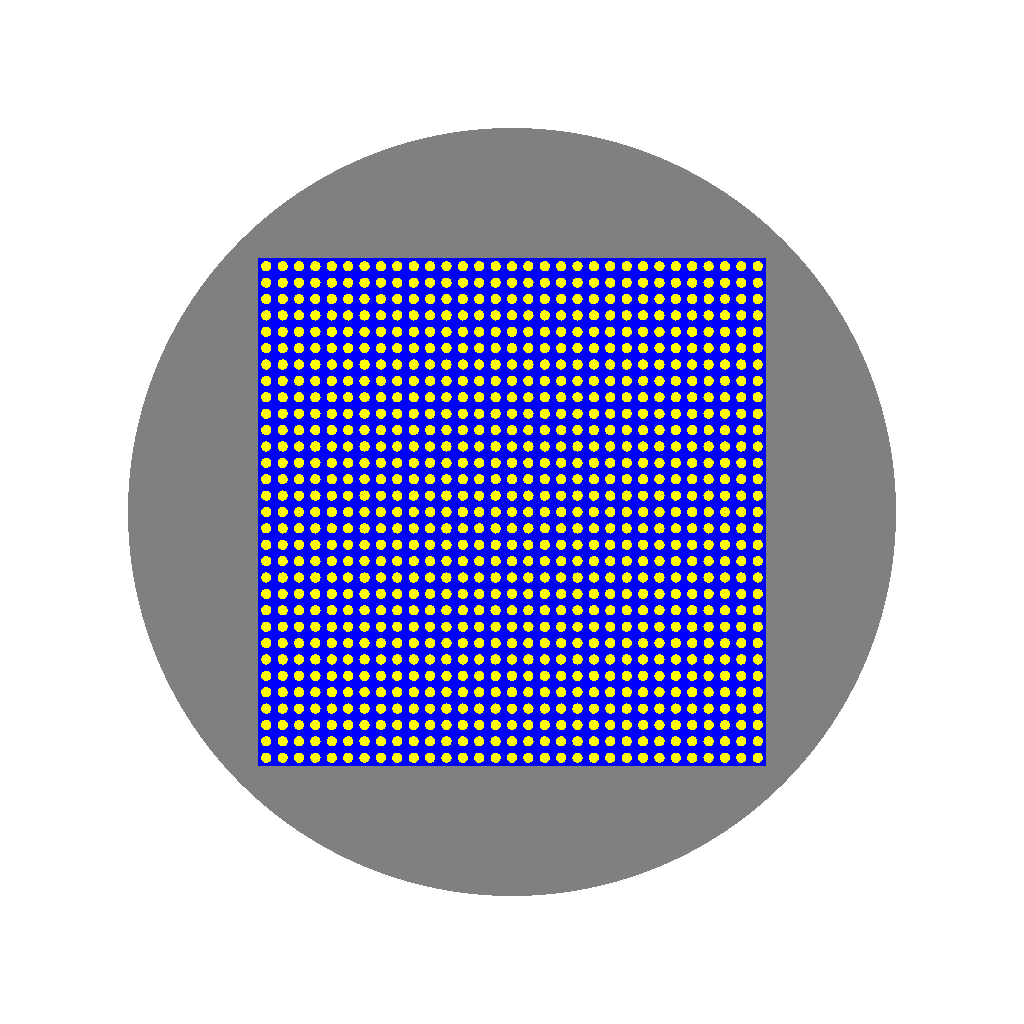

In [67]:
p = openmc.Plot();
p.width = [200., 200.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [68]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      172/1    0.60177    0.60680 +/- 0.00110
      173/1    0.63731    0.60722 +/- 0.00116
      174/1    0.61242    0.60729 +/- 0.00115
      175/1    0.59834    0.60717 +/- 0.00114
      176/1    0.60481    0.60714 +/- 0.00113
      177/1    0.61928    0.60730 +/- 0.00112
      178/1    0.60407    0.60726 +/- 0.00111
      179/1    0.62947    0.60754 +/- 0.00113
      180/1    0.60965    0.60757 +/- 0.00112
      181/1    0.61587    0.60767 +/- 0.00111
      182/1    0.62239    0.60785 +/- 0.00111
      183/1    0.61404    0.60792 +/- 0.00110
      184/1    0.61973    0.60806 +/- 0.00109
      185/1    0.59763    0.60794 +/- 0.00109
      186/1    0.60507    0.60791 +/- 0.00108
      187/1    0.61680    0.60801 +/- 0.00107
      188/1    0.61169    0.60805 +/- 0.00106
      189/1    0.61662    0.60815 +/- 0.00105
      190/1    0.63361    0.60843 +/- 0.00107
      191/1    0.61085    0.60846 +/- 0.00106
      192/1    0.61101    0.60848 +/- 0.00105
      193/1    0.59850    0.60838 

In [69]:
os.chdir('..')
if (not os.path.isdir('./partC')): #
    os.mkdir('./partC');
os.chdir('./partC');

## Part C
In this iteration of the analysis we increase the overall size of the reactor tank to 300 cm and, using the same 31x31 lattice, vary the pitch from 4cm to 12cm noting the change of $k_{\text{eff}}$ along the way.  

### Materials, Geometry, and Tallies
So - a few small changes are required but I thought it would be nice to have all of the relevent bits of code all together (for once).  T

In [70]:

fuel = openmc.Material(name='fuel');
fuel.add_nuclide('U238',0.99,'wo');
fuel.add_nuclide('U235',0.01,'wo');
fuel.set_density('g/cm3',19.1);

mod = openmc.Material(name='mod');
mod.add_nuclide('H2',2,'ao');
mod.add_nuclide('O16',1,'ao');
mod.add_s_alpha_beta('c_D_in_D2O');
mod.set_density('g/cm3',1.105);



mf = openmc.Materials();
mf += [fuel,mod];

mf.export_to_xml();


core_tank = openmc.model.RightCircularCylinder([0.,0.,-5.],
                                              150.,radius=300.,
                                               axis='z',
                                              boundary_type='vacuum');

core_cell = openmc.Cell();
core_cell.fill = h_core;
core_cell.region = -core_tank;

root_universe = openmc.Universe();
root_universe.add_cells([core_cell]);

geometry = openmc.Geometry(root_universe);
geometry.export_to_xml();


def gen_lattice_hw(l_pitch):
    #input lattice pitch
    
    n_pins = 31;
    pin_r = 1.; # cm, fuel pin radius
    
    fuel_pin = openmc.model.RightCircularCylinder([0.,0.,0.],100.,
                                              radius=pin_r,
                                              axis='z');

    fp_fuel = openmc.Cell(name='fuel');
    fp_fuel.fill = fuel;
    fp_fuel.region = -fuel_pin;

    fp_mod = openmc.Cell(name='mod in fuel');
    fp_mod.fill = mod;
    fp_mod.region = +fuel_pin;

    fp = openmc.Universe();
    fp.add_cells((fp_fuel,fp_mod));

    mod_cell = openmc.Cell();
    mod_cell.fill = mod;

    all_water = openmc.Universe();
    all_water.add_cell(mod_cell);
    
    core_bd = l_pitch*n_pins/2.
    core_area = openmc.model.RectangularParallelepiped(-core_bd,core_bd,-core_bd,core_bd,
                                                  0.,100.);

    lattice = openmc.RectLattice();
    lattice.dimension = [n_pins,n_pins];
    lattice.lower_left = [-core_bd,-core_bd];
    lattice.pitch = [l_pitch,l_pitch];

    lattice.universes = [[ fp for i in range(n_pins)]for j in range(n_pins)];
           

    lattice.outer = all_water;

    core_cell = openmc.Cell();
    core_cell.fill = lattice;
    core_cell.region = -core_area;

    refl_cell = openmc.Cell();
    refl_cell.fill = mod;
    refl_cell.region = +core_area & -core_tank;

    root = openmc.Universe();
    root.add_cells([core_cell,refl_cell]);

    g = openmc.Geometry();
    g.root_universe = root;
    g.export_to_xml();
    
    
    fuel_cell_filter = openmc.DistribcellFilter([fp_fuel]);
    mod_in_fuel_filter = openmc.DistribcellFilter([fp_mod]);
    rfl_cell_filter = openmc.CellFilter([refl_cell]);

    tallies = openmc.Tallies()

    abs_fuel = openmc.Tally(name='abs. fuel');
    abs_fuel.filters = [energy_filter,fuel_cell_filter];
    abs_fuel.scores = ['absorption'];
    abs_fuel.nuclides = ['U235','U238'];
    tallies.append(abs_fuel);

    abs_mod_ref = openmc.Tally(name='abs. mod refl');
    abs_mod_ref.filters = [energy_filter,rfl_cell_filter];
    abs_mod_ref.nuclides = ['H2','O16'];
    abs_mod_ref.scores = ['absorption'];
    tallies.append(abs_mod_ref);

    abs_mod_fuel = openmc.Tally(name='abs. mod fuel');
    abs_mod_fuel.filters = [energy_filter,mod_in_fuel_filter];
    abs_mod_fuel.nuclides = ['H2','O16'];
    abs_mod_fuel.scores = ['absorption'];
    tallies.append(abs_mod_fuel);


    t_fiss = openmc.Tally(name='fission tally');
    t_fiss.filters = [energy_filter,fuel_cell_filter];
    t_fiss.nuclides = ['U235','U238'];
    t_fiss.scores = ['fission','nu-fission'];
    tallies.append(t_fiss);

    tallies.export_to_xml();

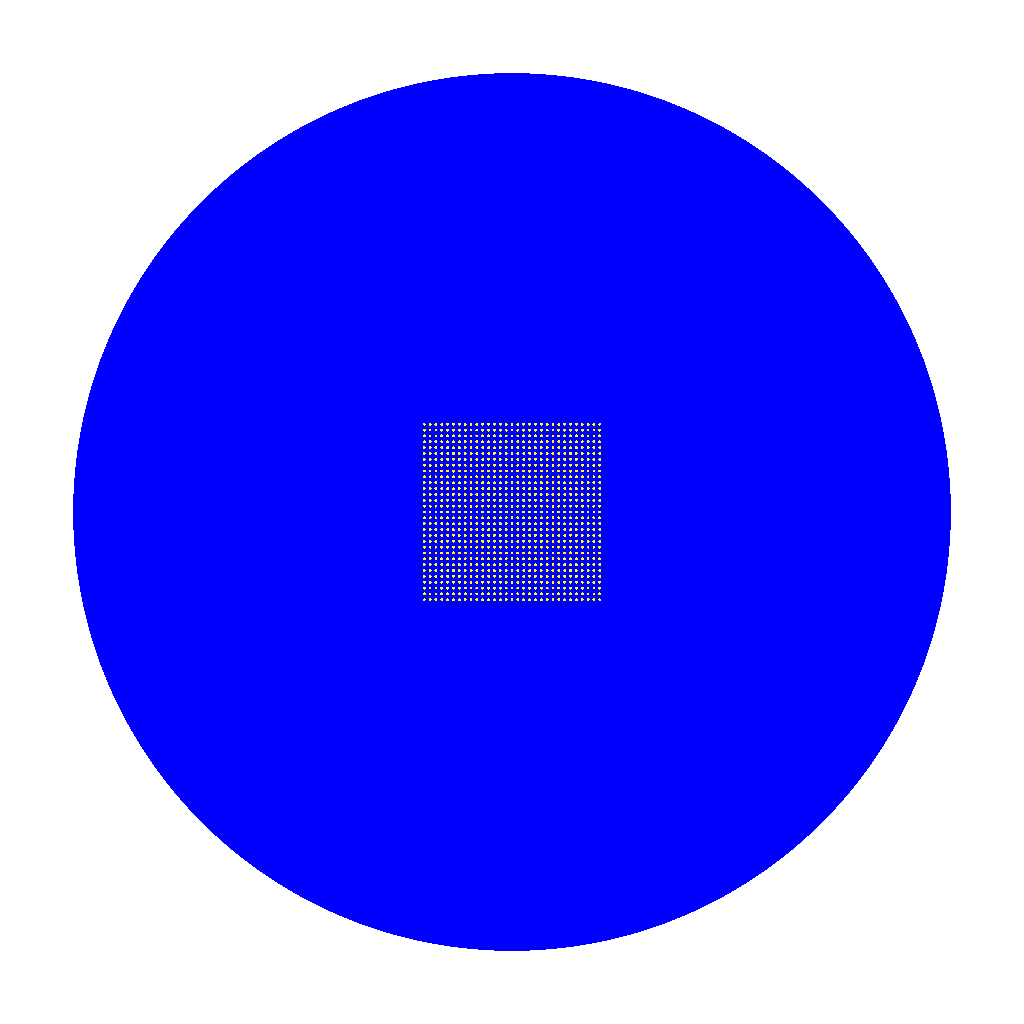

In [73]:
gen_lattice_hw(4.0);

colors = {}
colors[mod] = 'blue';
colors[fuel] = 'yellow';
#colors[graph_refl] = 'gray';

p = openmc.Plot();
p.width = [700., 700.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [74]:
settings.export_to_xml()

In [75]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      174/1    0.84511    0.85043 +/- 0.00171
      175/1    0.83635    0.85024 +/- 0.00169
      176/1    0.84394    0.85015 +/- 0.00167
      177/1    0.83395    0.84994 +/- 0.00166
      178/1    0.84095    0.84983 +/- 0.00165
      179/1    0.85540    0.84990 +/- 0.00163
      180/1    0.87092    0.85016 +/- 0.00163
      181/1    0.84816    0.85014 +/- 0.00161
      182/1    0.86657    0.85034 +/- 0.00160
      183/1    0.85810    0.85043 +/- 0.00158
      184/1    0.87093    0.85068 +/- 0.00158
      185/1    0.87768    0.85099 +/- 0.00160
      186/1    0.85354    0.85102 +/- 0.00158
      187/1    0.84170    0.85092 +/- 0.00156
      188/1    0.85717    0.85099 +/- 0.00155
      189/1    0.84089    0.85087 +/- 0.00154
      190/1    0.86245    0.85100 +/- 0.00152
      191/1    0.87087    0.85122 +/- 0.00152
      192/1    0.85852    0.85130 +/- 0.00151
      193/1    0.85133    0.85130 +/- 0.00149
      194/1    0.85523    0.85134 +/- 0.00148
      195/1    0.83853    0.85121 

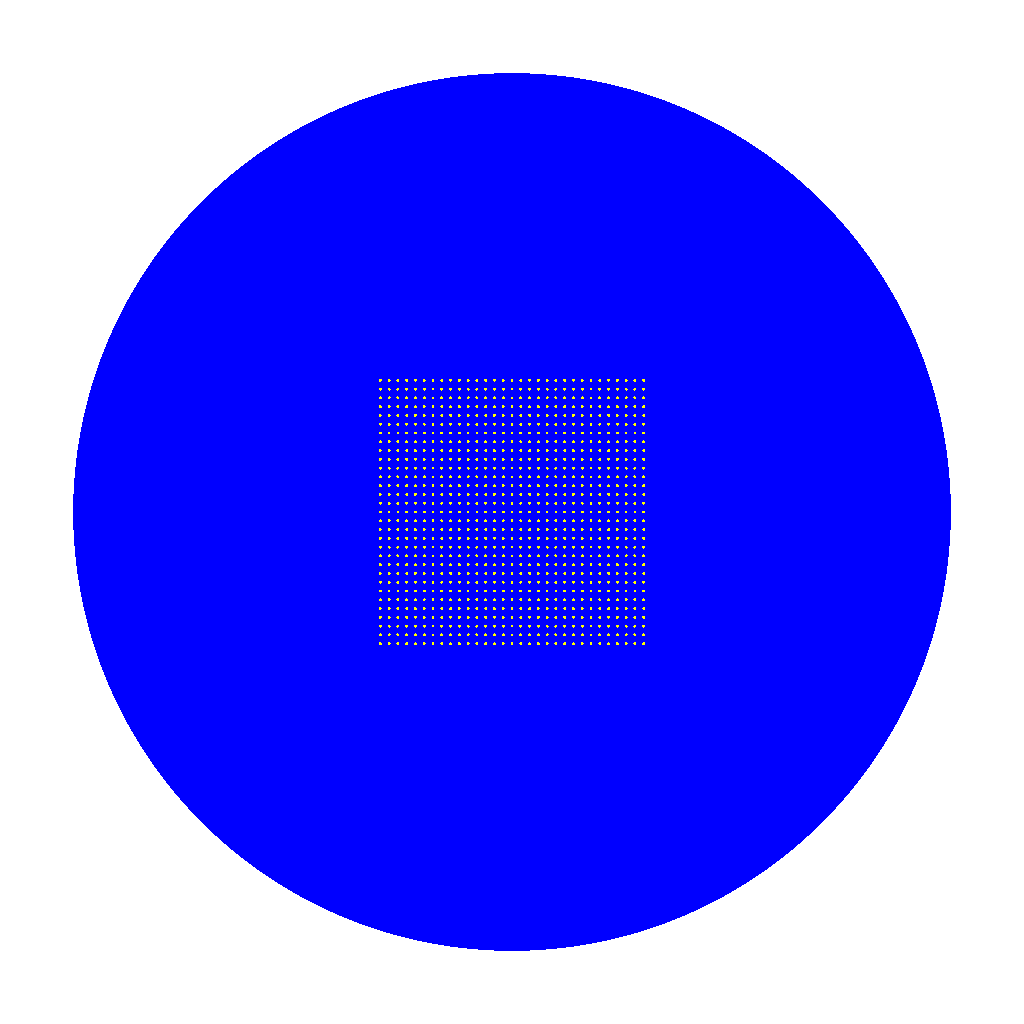

In [76]:
gen_lattice_hw(6.0);

colors = {}
colors[mod] = 'blue';
colors[fuel] = 'yellow';
#colors[graph_refl] = 'gray';

p = openmc.Plot();
p.width = [700., 700.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [77]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      175/1    1.07405    1.05979 +/- 0.00158
      176/1    1.07927    1.06004 +/- 0.00158
      177/1    1.06517    1.06011 +/- 0.00156
      178/1    1.05998    1.06011 +/- 0.00154
      179/1    1.05717    1.06007 +/- 0.00153
      180/1    1.06636    1.06015 +/- 0.00151
      181/1    1.07285    1.06031 +/- 0.00150
      182/1    1.04118    1.06007 +/- 0.00150
      183/1    1.05726    1.06004 +/- 0.00148
      184/1    1.06718    1.06013 +/- 0.00146
      185/1    1.04239    1.05992 +/- 0.00146
      186/1    1.06739    1.06000 +/- 0.00145
      187/1    1.05824    1.05998 +/- 0.00143
      188/1    1.06024    1.05999 +/- 0.00141
      189/1    1.07656    1.06017 +/- 0.00141
      190/1    1.04787    1.06004 +/- 0.00140
      191/1    1.06701    1.06011 +/- 0.00139
      192/1    1.04625    1.05996 +/- 0.00138
      193/1    1.07184    1.06009 +/- 0.00137
      194/1    1.05811    1.06007 +/- 0.00136
      195/1    1.05117    1.05998 +/- 0.00135
      196/1    1.04799    1.05985 

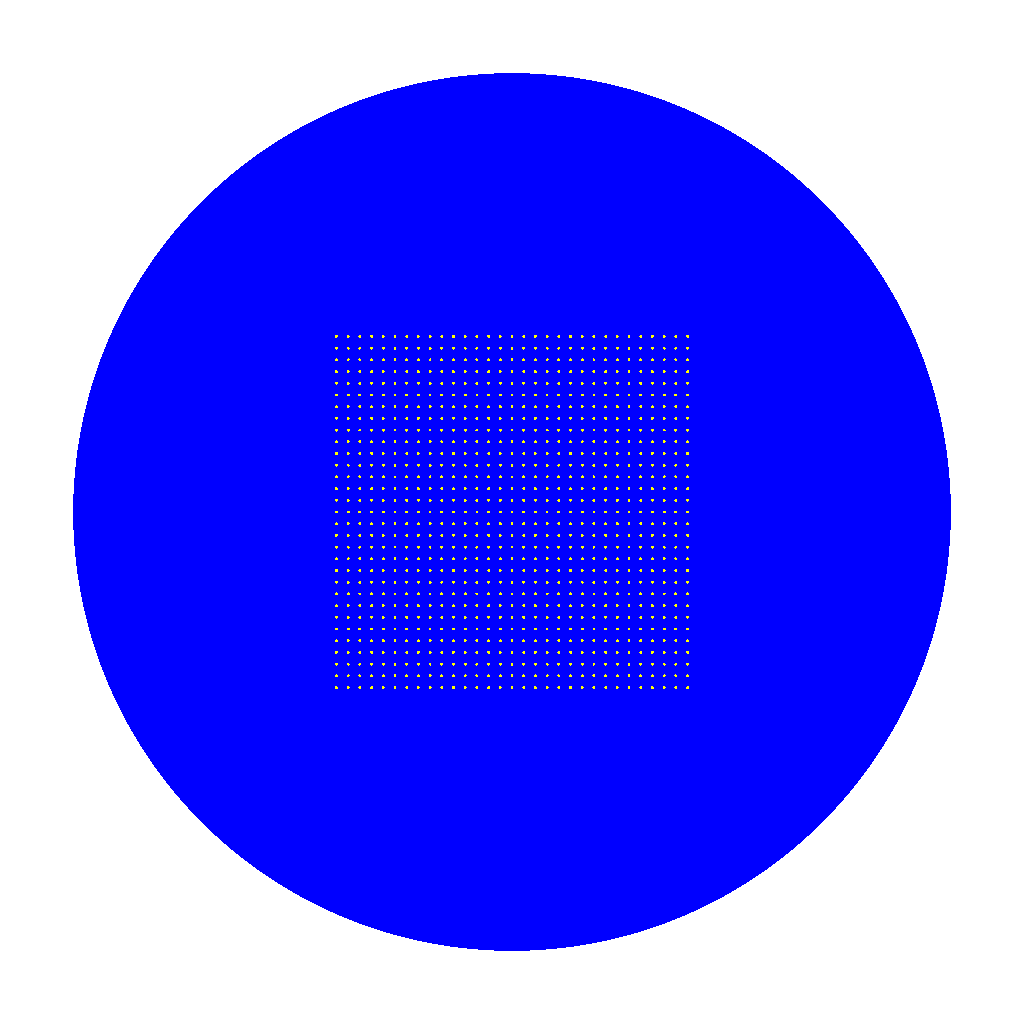

In [78]:
gen_lattice_hw(8.0);

colors = {}
colors[mod] = 'blue';
colors[fuel] = 'yellow';
#colors[graph_refl] = 'gray';

p = openmc.Plot();
p.width = [700., 700.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [79]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      174/1    1.15340    1.16261 +/- 0.00170
      175/1    1.16737    1.16267 +/- 0.00167
      176/1    1.14743    1.16247 +/- 0.00166
      177/1    1.16321    1.16248 +/- 0.00164
      178/1    1.16108    1.16246 +/- 0.00162
      179/1    1.14913    1.16229 +/- 0.00161
      180/1    1.18531    1.16258 +/- 0.00161
      181/1    1.17555    1.16274 +/- 0.00160
      182/1    1.14192    1.16249 +/- 0.00160
      183/1    1.16954    1.16257 +/- 0.00159
      184/1    1.16732    1.16263 +/- 0.00157
      185/1    1.15564    1.16255 +/- 0.00155
      186/1    1.16559    1.16258 +/- 0.00153
      187/1    1.14793    1.16241 +/- 0.00153
      188/1    1.16626    1.16246 +/- 0.00151
      189/1    1.15578    1.16238 +/- 0.00149
      190/1    1.13945    1.16213 +/- 0.00150
      191/1    1.12857    1.16176 +/- 0.00153
      192/1    1.16219    1.16176 +/- 0.00151
      193/1    1.17598    1.16192 +/- 0.00150
      194/1    1.15952    1.16189 +/- 0.00149
      195/1    1.16362    1.16191 

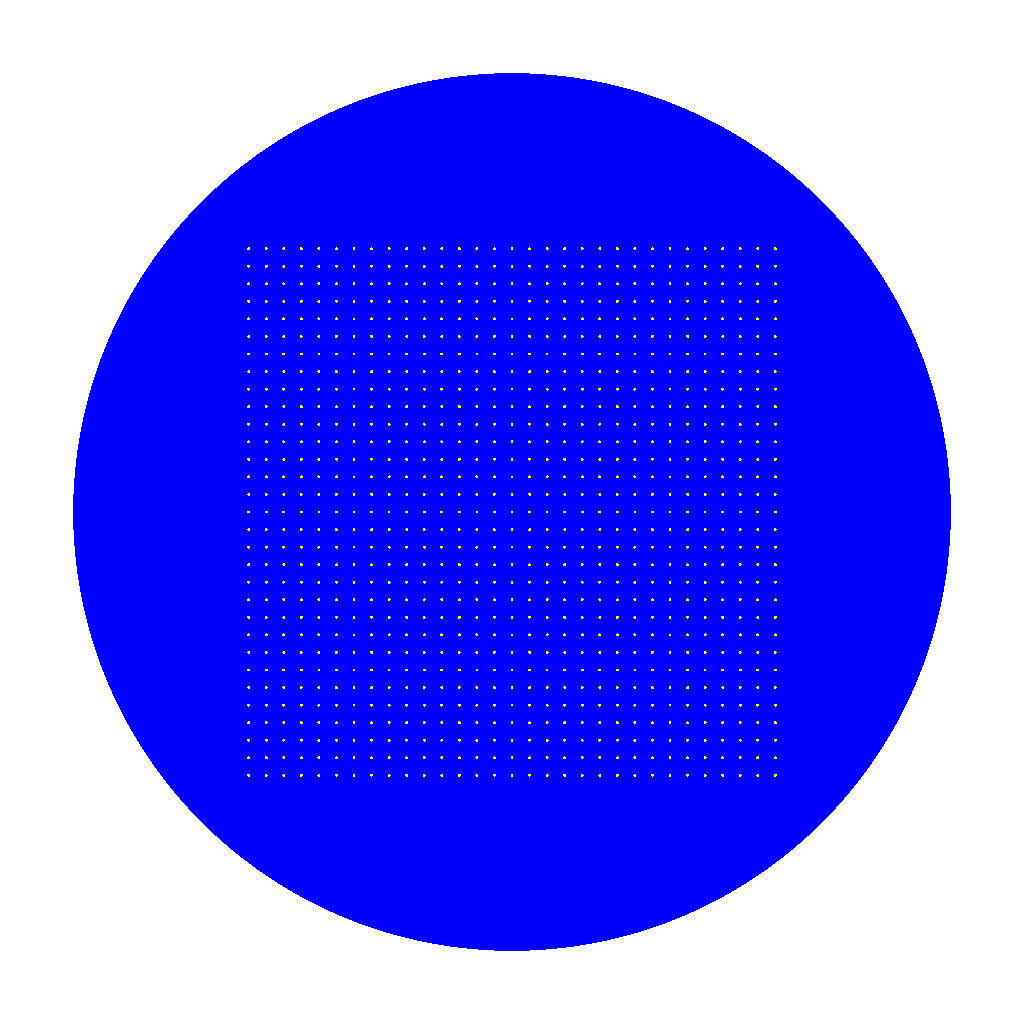

In [80]:
gen_lattice_hw(12.0);

colors = {}
colors[mod] = 'blue';
colors[fuel] = 'yellow';
#colors[graph_refl] = 'gray';

p = openmc.Plot();
p.width = [700., 700.];
p.origin = [0.,0.,10.];
p.pixels = [1024,1024];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [81]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      174/1    1.20533    1.20347 +/- 0.00175
      175/1    1.18096    1.20317 +/- 0.00175
      176/1    1.20073    1.20314 +/- 0.00173
      177/1    1.21957    1.20335 +/- 0.00172
      178/1    1.20765    1.20340 +/- 0.00170
      179/1    1.19998    1.20336 +/- 0.00168
      180/1    1.19492    1.20326 +/- 0.00166
      181/1    1.22480    1.20352 +/- 0.00166
      182/1    1.21665    1.20368 +/- 0.00165
      183/1    1.19420    1.20357 +/- 0.00163
      184/1    1.19767    1.20350 +/- 0.00161
      185/1    1.19596    1.20341 +/- 0.00160
      186/1    1.19407    1.20330 +/- 0.00158
      187/1    1.18122    1.20305 +/- 0.00158
      188/1    1.21019    1.20313 +/- 0.00157
      189/1    1.20009    1.20309 +/- 0.00155
      190/1    1.22371    1.20332 +/- 0.00155
      191/1    1.18881    1.20316 +/- 0.00154
      192/1    1.20613    1.20320 +/- 0.00152
      193/1    1.18932    1.20305 +/- 0.00152
      194/1    1.18035    1.20280 +/- 0.00152
      195/1    1.22699    1.20306 

In [82]:
core_tank = openmc.model.RightCircularCylinder([0.,0.,-5.],
                                              150.,radius=1000.,
                                               axis='z',
                                              boundary_type='vacuum');

core_cell = openmc.Cell();
core_cell.fill = h_core;
core_cell.region = -core_tank;

root_universe = openmc.Universe();
root_universe.add_cells([core_cell]);

geometry = openmc.Geometry(root_universe);
geometry.export_to_xml();


def gen_lattice_hw(l_pitch):
    #input lattice pitch
    
    n_pins = 31;
    pin_r = 1.; # cm, fuel pin radius
    
    fuel_pin = openmc.model.RightCircularCylinder([0.,0.,0.],100.,
                                              radius=pin_r,
                                              axis='z');

    fp_fuel = openmc.Cell(name='fuel');
    fp_fuel.fill = fuel;
    fp_fuel.region = -fuel_pin;

    fp_mod = openmc.Cell(name='mod in fuel');
    fp_mod.fill = mod;
    fp_mod.region = +fuel_pin;

    fp = openmc.Universe();
    fp.add_cells((fp_fuel,fp_mod));

    mod_cell = openmc.Cell();
    mod_cell.fill = mod;

    all_water = openmc.Universe();
    all_water.add_cell(mod_cell);
    
    core_bd = l_pitch*n_pins/2.
    core_area = openmc.model.RectangularParallelepiped(-core_bd,core_bd,-core_bd,core_bd,
                                                  0.,100.);

    lattice = openmc.RectLattice();
    lattice.dimension = [n_pins,n_pins];
    lattice.lower_left = [-core_bd,-core_bd];
    lattice.pitch = [l_pitch,l_pitch];

    lattice.universes = [[ fp for i in range(n_pins)]for j in range(n_pins)];
           

    lattice.outer = all_water;

    core_cell = openmc.Cell();
    core_cell.fill = lattice;
    core_cell.region = -core_area;

    refl_cell = openmc.Cell();
    refl_cell.fill = mod;
    refl_cell.region = +core_area & -core_tank;

    root = openmc.Universe();
    root.add_cells([core_cell,refl_cell]);

    g = openmc.Geometry();
    g.root_universe = root;
    g.export_to_xml();
    
    
    fuel_cell_filter = openmc.DistribcellFilter([fp_fuel]);
    mod_in_fuel_filter = openmc.DistribcellFilter([fp_mod]);
    rfl_cell_filter = openmc.CellFilter([refl_cell]);

    tallies = openmc.Tallies()

    abs_fuel = openmc.Tally(name='abs. fuel');
    abs_fuel.filters = [energy_filter,fuel_cell_filter];
    abs_fuel.scores = ['absorption'];
    abs_fuel.nuclides = ['U235','U238'];
    tallies.append(abs_fuel);

    abs_mod_ref = openmc.Tally(name='abs. mod refl');
    abs_mod_ref.filters = [energy_filter,rfl_cell_filter];
    abs_mod_ref.nuclides = ['H2','O16'];
    abs_mod_ref.scores = ['absorption'];
    tallies.append(abs_mod_ref);

    abs_mod_fuel = openmc.Tally(name='abs. mod fuel');
    abs_mod_fuel.filters = [energy_filter,mod_in_fuel_filter];
    abs_mod_fuel.nuclides = ['H2','O16'];
    abs_mod_fuel.scores = ['absorption'];
    tallies.append(abs_mod_fuel);


    t_fiss = openmc.Tally(name='fission tally');
    t_fiss.filters = [energy_filter,fuel_cell_filter];
    t_fiss.nuclides = ['U235','U238'];
    t_fiss.scores = ['fission','nu-fission'];
    tallies.append(t_fiss);

    tallies.export_to_xml();

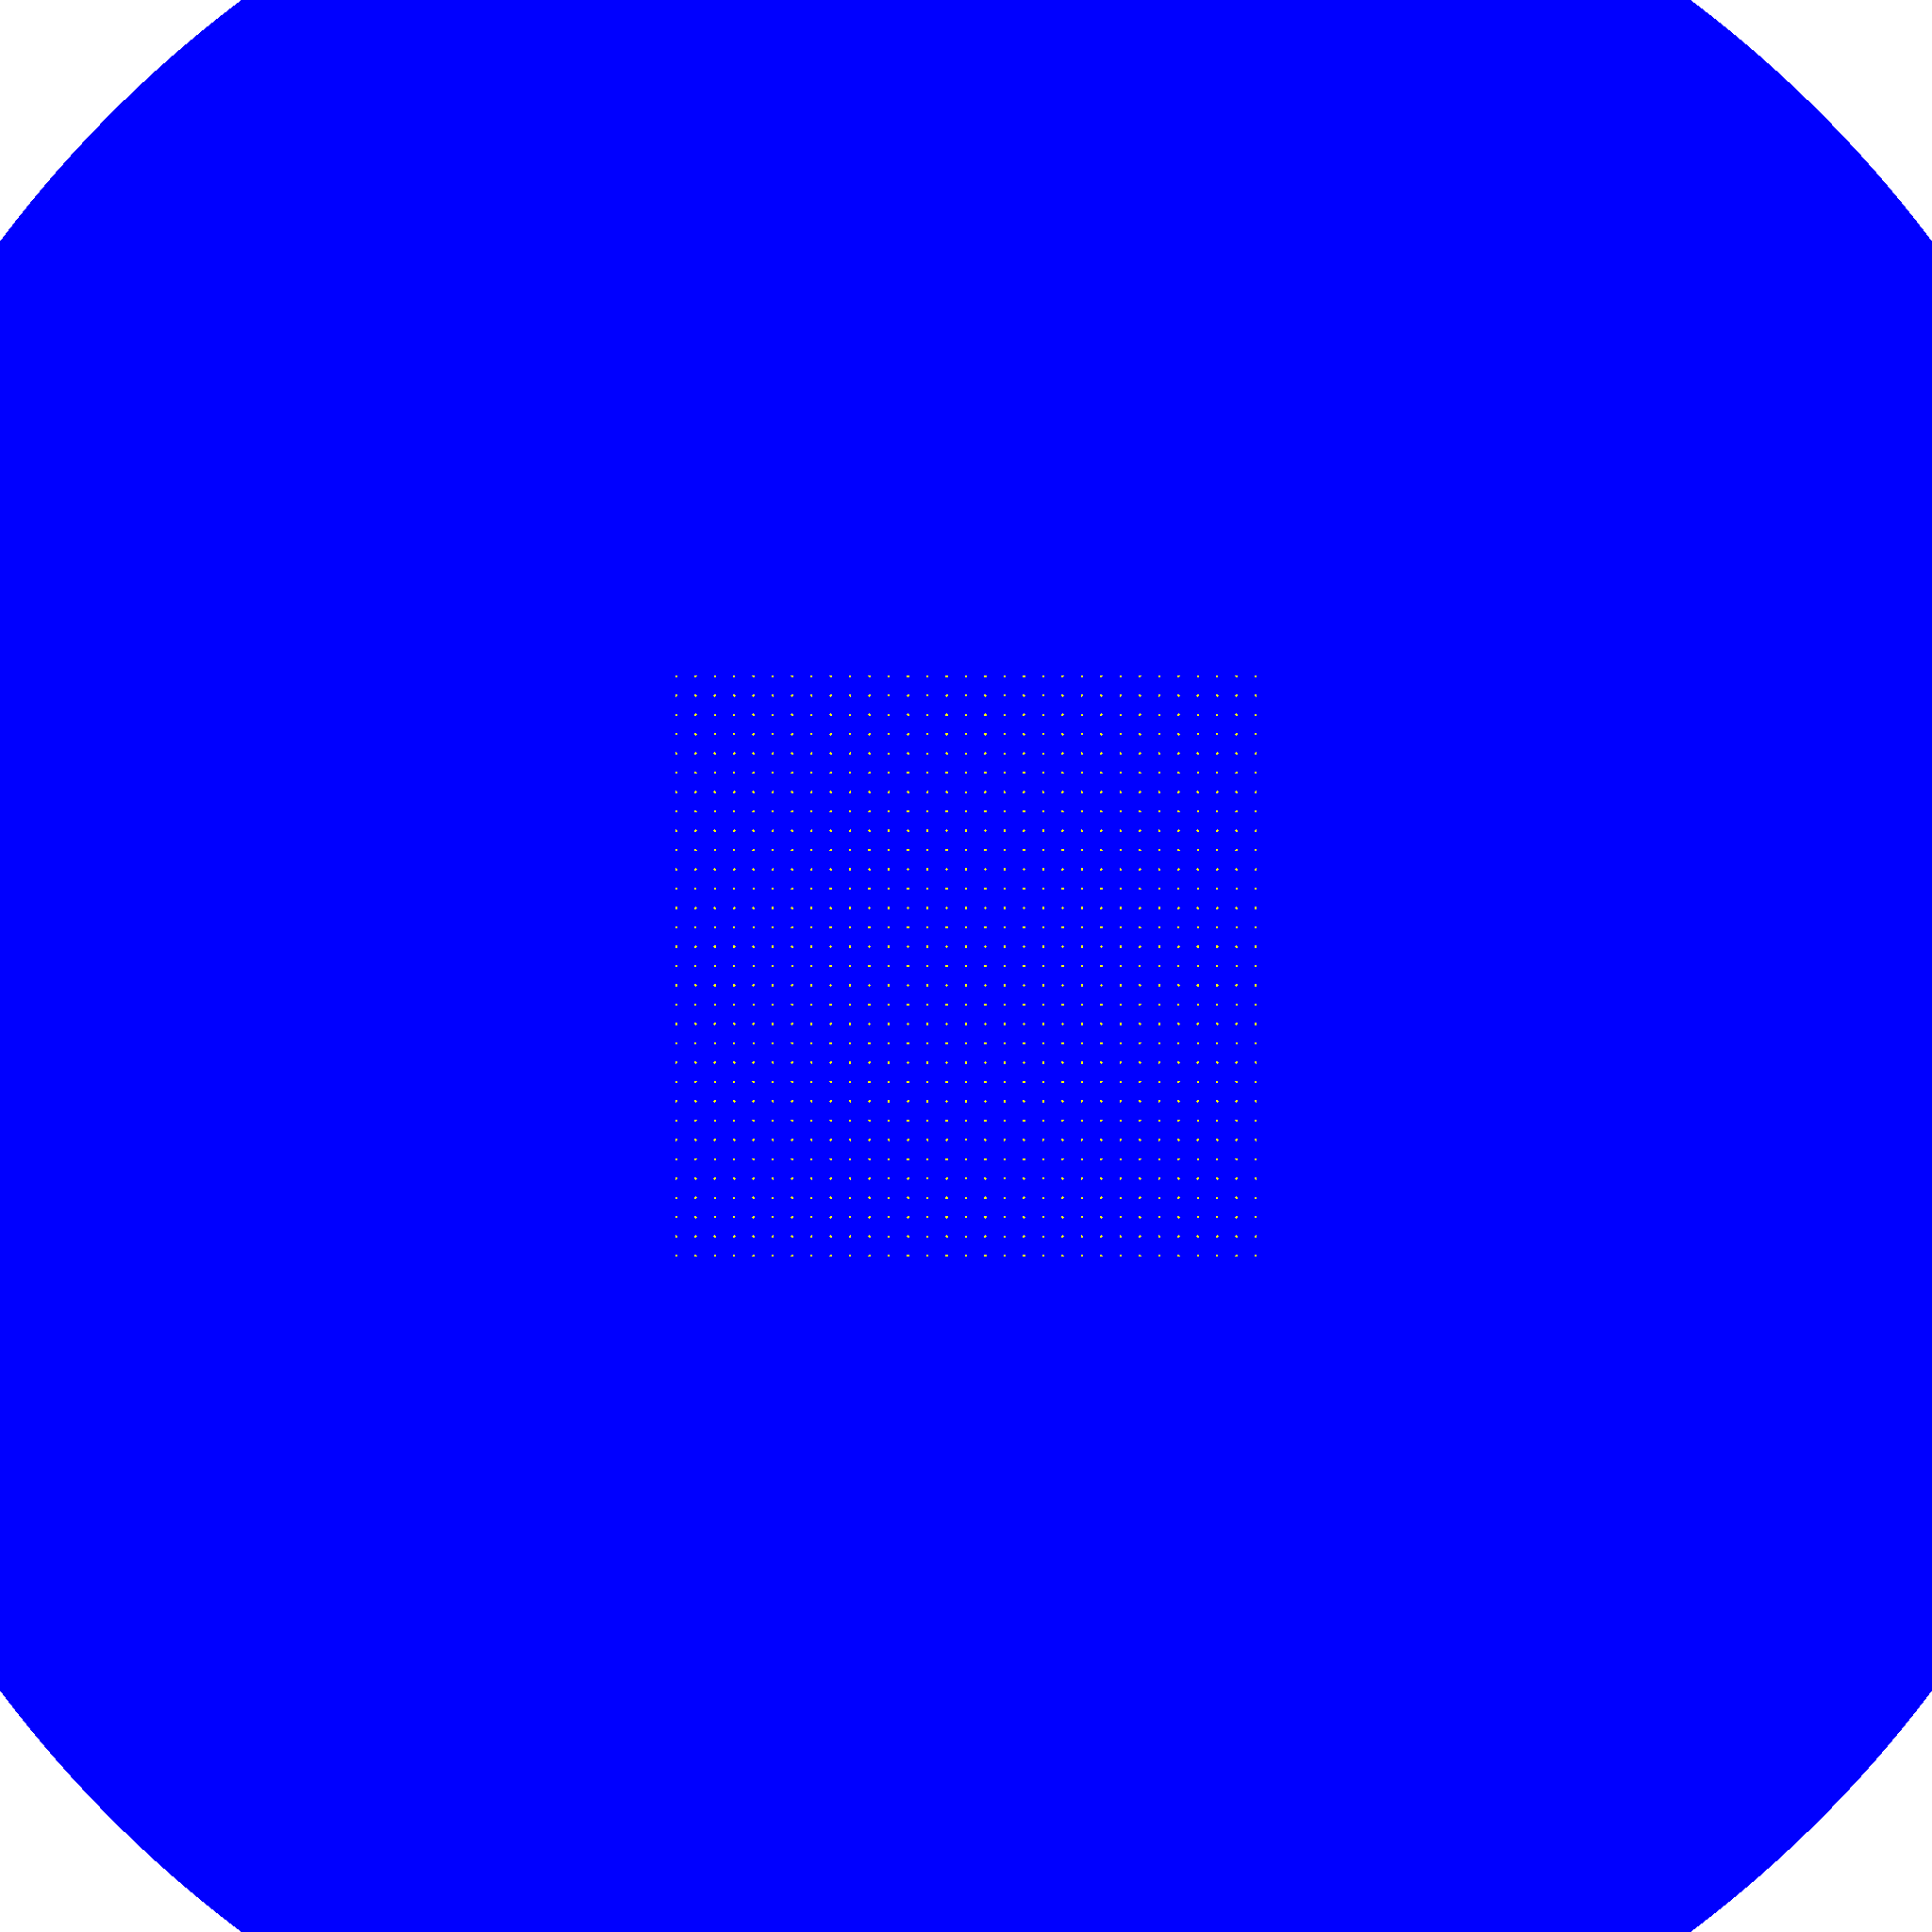

In [93]:
gen_lattice_hw(16.0);

colors = {}
colors[mod] = 'blue';
colors[fuel] = 'yellow';

p = openmc.Plot();
p.width = [1600., 1600.];
p.origin = [0.,0.,10.];
p.pixels = [2048,2048];
p.color_by = 'material';
p.colors = colors

openmc.plot_inline(p);

In [94]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      175/1    1.17611    1.16631 +/- 0.00126
      176/1    1.14473    1.16603 +/- 0.00128
      177/1    1.16851    1.16606 +/- 0.00126
      178/1    1.16896    1.16610 +/- 0.00125
      179/1    1.16348    1.16606 +/- 0.00123
      180/1    1.18461    1.16630 +/- 0.00124
      181/1    1.17001    1.16634 +/- 0.00122
      182/1    1.14667    1.16610 +/- 0.00123
      183/1    1.17727    1.16624 +/- 0.00122
      184/1    1.14593    1.16599 +/- 0.00123
      185/1    1.15937    1.16592 +/- 0.00122
      186/1    1.15762    1.16582 +/- 0.00121
      187/1    1.18045    1.16599 +/- 0.00121
      188/1    1.16840    1.16602 +/- 0.00119
      189/1    1.14503    1.16578 +/- 0.00120
      190/1    1.19380    1.16609 +/- 0.00123
      191/1    1.19652    1.16643 +/- 0.00126
      192/1    1.16678    1.16643 +/- 0.00125
      193/1    1.18277    1.16660 +/- 0.00125
      194/1    1.12961    1.16621 +/- 0.00130
      195/1    1.15344    1.16608 +/- 0.00129
      196/1    1.15558    1.16597 

In [95]:
gen_lattice_hw(20.0);

openmc.run();

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      174/1    1.06856    1.09294 +/- 0.00159
      175/1    1.08387    1.09282 +/- 0.00157
      176/1    1.09403    1.09283 +/- 0.00155
      177/1    1.07675    1.09262 +/- 0.00155
      178/1    1.10716    1.09281 +/- 0.00154
      179/1    1.09342    1.09282 +/- 0.00152
      180/1    1.07088    1.09254 +/- 0.00152
      181/1    1.10818    1.09274 +/- 0.00152
      182/1    1.10937    1.09294 +/- 0.00151
      183/1    1.09825    1.09300 +/- 0.00150
      184/1    1.07420    1.09278 +/- 0.00149
      185/1    1.10055    1.09287 +/- 0.00148
      186/1    1.09905    1.09294 +/- 0.00146
      187/1    1.06505    1.09262 +/- 0.00148
      188/1    1.09562    1.09266 +/- 0.00147
      189/1    1.09653    1.09270 +/- 0.00145
      190/1    1.06825    1.09243 +/- 0.00146
      191/1    1.09177    1.09242 +/- 0.00144
      192/1    1.10359    1.09254 +/- 0.00143
      193/1    1.07380    1.09234 +/- 0.00143
      194/1    1.08834    1.09230 +/- 0.00142
      195/1    1.07810    1.09215 

Okay...so that's probably enough playing for one day. I need to re-visit this lab and perhaps slow down to look more carefully at what is going on.  Clearly $k_{\text{eff}}$ has gone through a peak although that peak is not shown in the current revision of lab 6 where the lattice pitch is no greater than 12.  The peak is somewhere between 12 and 16 cm; increasing the pitch to 20 cm further reduces $k_{\text{eff}}$.  What I *think* is happening is that the core is going from an undermoderated to an overmoderated configuration. That might not be a great description since a lot of neutrons are escaping  